In [65]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals
import pints.toy as toy
import pints
import numpy as np
import logging
import math
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import sys
from numpy import inf
import copy 

model_dict = dict()

In [66]:
# LOGISTIC MODEL # 
log_dict = dict()

log_dict['name'] = "Logistic model"
log_dict['model'] = toy.LogisticModel()

log_dict['real_parameters'] = [0.5, 500]
log_dict['times']  = log_dict['model'].suggested_times()

log_dict['boundaries'] = pints.RectangularBoundaries([0, 200], [1, 1000])

# Choose an initial position
log_dict['x0'] = [0.2, 420]

model_dict['Logistic'] = log_dict

In [67]:
# Beeler Reuter Act Pot #
BR_dict = dict()

BR_dict['name'] = "Beeler Reuter Action Potential model" 
BR_dict['model'] = toy.ActionPotentialModel()

BR_dict['real_parameters'] = BR_dict['model'].suggested_parameters() # 4.0, 0.003, 0.09, 0.35, 0.8
BR_dict['times'] = BR_dict['model'].suggested_times()

BR_dict['boudaries'] = pints.RectangularBoundaries([-20, -2, -2, -2, -2], [20, 2, 2, 2, 2])

BR_dict['x0'] = np.log([3.0, 0.001, 0.06, 0.29, 0.6])

model_dict['Beeler_Reuter'] = BR_dict

In [68]:
# HH_IK #
HH_dict = dict()

HH_dict['name'] = "Hodgkin Huxley IK model"
HH_dict['model'] = toy.HodgkinHuxleyIKModel()

HH_dict['real_parameters'] = HH_dict['model'].suggested_parameters() # 0.01, 10, 10, 0.125, 80
HH_dict['times'] = HH_dict['model'].suggested_times()

HH_dict['boudaries'] = pints.RectangularBoundaries([-2, -200, -200, -2, -200], [2, 200, 200, 2, 200])

HH_dict['x0'] = 0.001, 5, 20, 0.335, 37

model_dict['Hodgkin_Huxley'] = HH_dict

In [69]:
# HES_1 #
H1_dict = dict()

H1_dict['name'] = "HES1 Michaelis-Menten"
H1_dict['model'] = toy.Hes1Model()

H1_dict['real_parameters'] = H1_dict['model'].suggested_parameters() #[2.4, 0.025, 0.11, 6.9]
H1_dict['times'] = H1_dict['model'].suggested_times()

H1_dict['boudaries'] = pints.RectangularBoundaries([-20, -2, -2, -200], [20, 2, 2, 200])

H1_dict['x0'] = [7, 0.35, 0.9, 20]

model_dict['HES Michaelis-Menten'] = H1_dict

In [70]:
# GoodwinOscillatorModel #
GOM_dict = dict()

GOM_dict['name'] = "Goodwin Oscillator Model"
GOM_dict['model'] = toy.GoodwinOscillatorModel()

GOM_dict['real_parameters'] = GOM_dict['model'].suggested_parameters() #[2, 4, 0.12, 0.08, 0.1]
GOM_dict['times'] = GOM_dict['model'].suggested_times()

GOM_dict['boudaries'] = pints.RectangularBoundaries([-20, -200, -2, -2, -2], [20, 200, 2, 2, 2])

GOM_dict['x0'] = [10, 15, 0.7, 0.40, 0.9]

model_dict['Three-state Goodwin oscillator'] = GOM_dict


Currently testing on Logistic
Starting CMA
Failed 0 times
Average best score for CMA after 5 trials 103.74609648377418


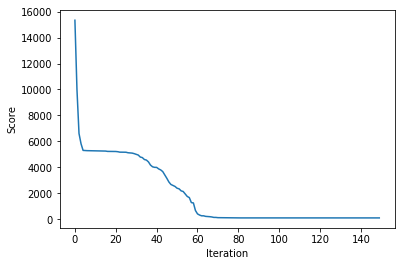

Starting CMA-NOT
Failed 0 times
Average best score for CMA-NOT after 5 trials 103.74609648375201


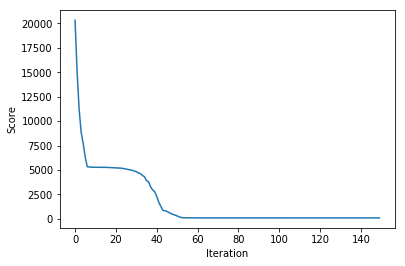

Starting SNES
Failed 0 times
Average best score for SNES after 5 trials 103.74609648375204


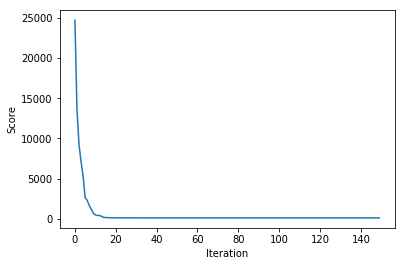

Starting XNES
Failed 0 times
Average best score for XNES after 5 trials 103.74609648375198


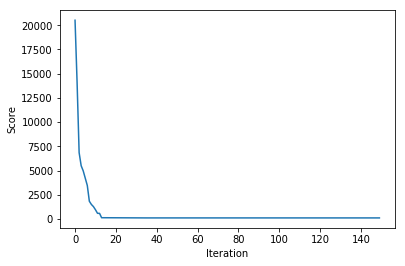

All scores


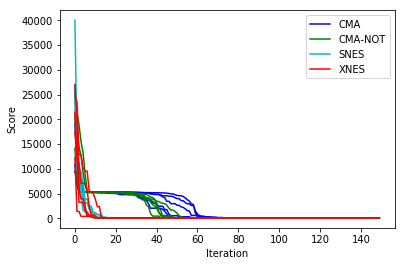

Done with Logistic
############################################
Currently testing on Beeler_Reuter
Starting CMA
Failed 0 times
Average best score for CMA after 5 trials 104.51984329669258


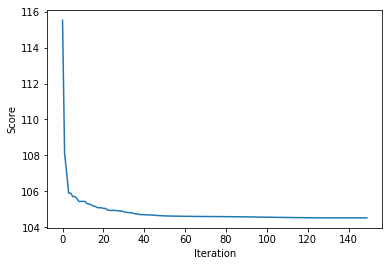

Starting CMA-NOT
Failed 0 times
Average best score for CMA-NOT after 5 trials 104.51944344860053


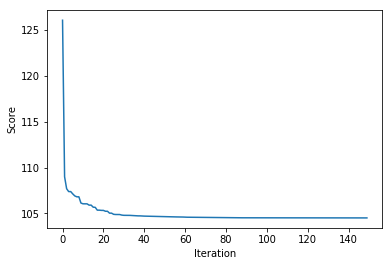

Starting SNES
Failed 0 times
Average best score for SNES after 5 trials 105.78090410305819


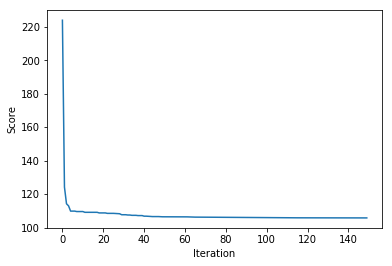

Starting XNES


In [ ]:
for key, value in model_dict.items():
    
    print("Currently testing on", key)
    
    x0 = value['x0']

    xnes = pints.XNES(x0)
    snes = pints.SNES(x0)
    cma_not = pints.CMAES(x0)
    cma = CMAES(x0)
    sgd = SGD(x0)

    opts = [ ("CMA", cma, "b"),("CMA-NOT",cma_not, "g"),  ("SNES", snes, "c"), ("XNES", xnes, "r")]

    model_testbed(value['model'], value['real_parameters'], value['times'], opts)
    
    print("Done with", key)
    print('############################################')

In [64]:
def model_testbed(model,
                  real_parameters,
                  times,
                  optimizers_info,
                  iterations=150,
                  tries=10):
    
    #Generate the values
    try:
        values, _ = model.simulateS1(real_parameters, times)
    except:
        values = model.simulate(real_parameters, times)
        
    # Add noise
    values += np.random.normal(0, 10, values.shape)
    # Create an object with links to the model and time series
    try:
        my_problem = pints.SingleOutputProblem(model, times, values)
    except:
        my_problem = pints.MultiOutputProblem(model, times, values)
    
    # Select a score function
    score = pints.MeanSquaredError(my_problem)
    
    all_results_info = list()
    
    for name, start_opt, color in optimizers_info:
        print("Starting", name)
        avg_best_fxs = []
        all_best_fxs = []
        avg_best_xs = []
        fail_count = 0
        for j in range(tries):
            opt = copy.copy(start_opt)
            best_fxs = []
            best_xs = []
            try:
                for i in range(iterations):
                    xs = opt.ask()
                    # Save the values for the plot 
                    if (i) % 5 == 0:
                        best_xs.append(opt.xbest())
                    # Evaluate the scores
                    fxs = [score(x) for x in xs]
                    opt.tell(fxs)
                    # Store the best score
                    best_fxs.append(opt.fbest())
                all_best_fxs.append(best_fxs)
            except Exception as e:
                print('One run failed: ', e)
                print()
                fail_count += 1
        avg_best_fxs = np.average(all_best_fxs, 0)
        all_results_info.append((all_best_fxs, color, name))
        
        # Show how the score converges
        print("Failed", fail_count, "times")
        print("Average best score for", name, "after", tries , "trials", avg_best_fxs[-1])
        axes = plt.gca()
        plt.xlabel('Iteration')
        plt.ylabel('Score')
        plt.plot(avg_best_fxs)
        plt.show()
    
    # Show how the score converges
    print("All scores")
    axes = plt.gca()
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    for best_fxs, color, name in all_results_info:
        for i in range(len(best_fxs)):
            if i == 0:
                plt.plot(best_fxs[i], color, label=name)
            else:
                plt.plot(best_fxs[i], color)
    plt.legend(loc='upper right')
    plt.show()
            

In [8]:
class CMAES(pints.PopulationBasedOptimiser):
    """
    Finds the best parameters using the CMA-ES method described in [1, 2].
    
    CMA-ES stands for Covariance Matrix Adaptation Evolution Strategy, and is
    designed for non-linear derivative-free optimization problems.
    
    *Extends:* :class:`PopulationBasedOptimiser`
    
    [1] https://arxiv.org/pdf/1604.00772.pdf
    
    [2] Hansen, Mueller, Koumoutsakos (2006) Reducing the time complexity of
    the derandomized evolution strategy with covariance matrix adaptation
    (CMA-ES).
    
    Important note: The parameter parent_pop_size is the mu in the papers. It represents the size of a parent population 
        used to update our paramters. 
    
    """

    def __init__(self, x0, sigma0=0.1, boundaries=None):
        super(CMAES, self).__init__(x0, sigma0, boundaries)

        # Set initial state
        self._running = False
        self._ready_for_tell = False

        # Best solution found
        self._xbest = pints.vector(x0)
        self._fbest = float('inf')
        
        # Python logger
        self._logger = logging.getLogger(__name__)
                
        self._counter = 0
            
    def set_print(self, v):
        self._printing = v
    
    def ask(self):
        """ See :meth:`Optimiser.ask()`. """
        # Initialise on first call
        if not self._running:
            self._initialise()

        # Ready for tell now
        self._ready_for_tell = True

        # Create new samples
        self._zs = np.array([np.random.multivariate_normal([0] * self._n_parameters, np.identity(self._n_parameters)) 
                   for _ in range(self._population_size)])
        
        self._ys = np.array([self._B.dot(self._D).dot(z) for z in self._zs])
        
        self._user_xs = self._xs = np.array([self._x0 + self._sigma0 * self._ys[i] 
                                             for i in range(self._population_size)])
        
        # Set as read-only and return
        self._user_xs.setflags(write=False)
        return self._user_xs

    def fbest(self):
        """ See :meth:`Optimiser.fbest()`. """
        if not self._running:
            return float('inf')
        return self._fbest

    def _initialise(self):
        """
        Initialises the optimiser for the first iteration.
        """
        assert(not self._running)


        # CMA-ES wants a single standard deviation as input, use the smallest
        # in the vector (if the user passed in a scalar, this will be the
        # value used). THIS IS ALSO THE STEP SIZE
        self._sigma0 = np.min(self._sigma0)
        
        # Eigenvectors
        self._B = np.identity(self._n_parameters)
        # SquareRoot of Diagnonal of EigenValues
        self._D = np.identity(self._n_parameters)
        # Cov-matrix (also identity)
        self._C = self._B.dot(self._D).dot(self._D.T).dot(self._B.T)
        
        # Parent generation population size
        # Not sure if the limitation to dim is good
        # This limitation is supposed to prevent a mistake in the update of the Covariance
        # matrix (C) with the rank mu update 
        self._parent_pop_size = self._population_size // 2 
                                    
        # Weights, all set equal for the moment (not sure how they are actually defined)
        # Sum of all positive weights should be 1
        self._W = [ math.log((self._population_size +1)/2.) - math.log(i) for i in range(1,self._population_size+1)]
        
        # Inverse of the Sum of the first parent weights squared (variance effective selection mass)                       
        self._muEff = np.sum(self._W[:self._parent_pop_size])**2 / np.sum(np.square(self._W[:self._parent_pop_size]))  

        # Inverse of the Sum of the last weights squared (variance effective selection mass)                       
        self._muEffMinus = np.sum(self._W[self._parent_pop_size:])**2 / np.sum(np.square(self._W[self._parent_pop_size:]))  
        
        # cumulation, evolution paths, used to update Cov matrix and sigma)
        self._pc = np.zeros(self._n_parameters)
        self._psig = np.zeros(self._n_parameters)

        # learning rate for the mean
        self._cm = 1
        
        # Decay rate of the evolution path for C
        self._ccov = (4 + self._muEff/self._n_parameters ) / (self._n_parameters + 4 + 2*self._muEff/self._n_parameters )
        
        # Decay rate of the evolution path for sigma
        self._csig = (2 + self._muEff) / (self._n_parameters + 5 + self._muEff)

        # See rank-1 vs rank-mu updates 
        # Learning rate for rank-1 update
        self._c1 = 2 / ((self._n_parameters + 1.3)**2 + self._muEff)
        
        # Learning rate for rank-mu update
        self._cmu = min( 2 * (self._muEff - 2 + 1 / self._muEff) / ((self._n_parameters + 2)**2 + self._muEff)
                        , 1 - self._c1)
        
        # Damping of the step-size (sigma0) update
        self._dsig = 1 + 2 * max(0,math.sqrt((self._muEff - 1) / (self._n_parameters + 1)) -1) + self._csig
                
            
        # Parameters from the Table 1 of [1]
        alphaMu = 1 + self._c1/ self._cmu 
        alphaMuEff = 1 + 2*self._muEffMinus/(self._muEff + 2)
        alphaPosDef = (1 - self._c1 - self._cmu)/ (self._n_parameters * self._cmu)
        
        # Rescaling the weights
        sum_pos = sum([ self._W[i] if self._W[i] > 0 else 0 for i in range(self._population_size)])
        sum_neg = sum([ self._W[i] if self._W[i] < 0 else 0 for i in range(self._population_size)])
        
        self._W = [ self._W[i] / sum_pos  
                   if self._W[i] >= 0
                   else self._W[i] * min(alphaMu, alphaMuEff, alphaPosDef)/-sum_neg
                  for i in range(self._population_size)]

        # CMAES always seeds np.random, whether you ask it too or not, so to
        # get consistent debugging output, we should always pass in a seed.
        # Instead of using a fixed number (which would be bad), we can use a
        # randomly generated number: This will ensure pseudo-randomness, but
        # produce consistent results if np.random has been seeded before
        # calling.
        self._seed = 2**31

        # Update optimiser state
        self._running = True

    def name(self):
        """ See :meth:`Optimiser.name()`. """
        return 'Covariance Matrix Adaptation Evolution Strategy (CMA-ES)'

    def running(self):
        """ See :meth:`Optimiser.running()`. """
        return self._running

    def stop(self):
        """ See :meth:`Optimiser.stop()`. """
        if not self._running:
            return False
        stop = self._es.stop()
        if stop:
            if 'tolconditioncov' in stop:    # pragma: no cover
                return 'Ill-conditioned covariance matrix.'

            self._logger.debug(
                'CMA-ES stopping condition(s) reached: ' +
                '; '.join([str(x) for x in stop.keys()]))
        return False
    
    ## TODO
    def _stop(self):
        return 
        

    def _suggested_population_size(self):
        """ See :meth:`Optimiser._suggested_population_size(). """
        return 4 + int(3 * np.log(self._n_parameters))

    def tell(self, fx):
        """ See :meth:`Optimiser.tell()`. """
        if not self._ready_for_tell:
            raise Exception('ask() not called before tell()')
        self._ready_for_tell = False
        
        self._counter += 1
        
        fx[ fx == inf ] = sys.maxsize
                
        # Get the best xs according to the fx results
        order = np.argsort(fx)
        xs_bests = np.array(self._xs[order])
        zs_bests = np.array(self._zs[order])
        ys_bests = np.array(self._ys[order]) # = np.array((xs_bests - self._x0) / self._sigma0)
        
        # Update the mean
        old_x0 = self._x0
        self._x0 = self._x0 + self._cm * np.sum(np.multiply((xs_bests[:self._parent_pop_size] - self._x0).T,
                                                            self._W[:self._parent_pop_size]).T , 0)
       
        # Normalizing constants for the evolution path udpate
        norm_cst_sig = math.sqrt(self._csig * (2 - self._csig) * self._muEff)
        norm_cst_c = math.sqrt(self._ccov * (2 - self._ccov) * self._muEff)

        
        # Get the weighted means of y and z
        zmeans = np.sum(np.multiply(zs_bests[:self._parent_pop_size].T,self._W[:self._parent_pop_size]).T,0)
        ymeans = np.sum(np.multiply(ys_bests[:self._parent_pop_size].T,self._W[:self._parent_pop_size]).T,0)
        
        # Evolution path of sigma (the step size)
        # Note that self._B.dot(zmeans) = self._B.dot(np.linalg.inv(self._D)).dot(self._B.T).dot(ymeans)
        self._psig = (1 - self._csig) * self._psig + norm_cst_sig * self._B.dot(zmeans)
        
        # Heaviside function helps to stall the of pc if norm ||psig|| is too large. 
        # This helps to prevent too fast increases in the axes of C when the step size are too small. 
        exp_size_N0I = (math.sqrt(2) * math.gamma((self._n_parameters + 1)/2) / math.gamma(self._n_parameters/2))
        
        h_sig = 1 if np.linalg.norm(self._psig)/ math.sqrt(1-(1-self._csig)**(2 * (self._counter + 1))) < \
                        (1.4 + 2/(self._n_parameters+1)) * exp_size_N0I else 0
        
        delta_sig = (1 - h_sig) * self._ccov * (2 - self._ccov)
        
        #Evolution path for the rank-1 update
        self._pc = (1 - self._ccov) * self._pc + h_sig * norm_cst_c * ymeans
        
        # Weight changes taken from the tutorial (no explanation is given for the change)
        # these weights are used for the rank mu update only
        # They allow to keep positive definiteness according to https://github.com/CMA-ES/pycma/blob/3abf6900e04d0619f4bfba989dde9e093fa8e1ba/cma/purecma.py#L419
        # USED 
        temp_weights = [self._W[i] if self._W[i]>=0 
                        else self._W[i] * self._n_parameters / (np.linalg.norm(self._B * zs_bests[i])**2) 
                        for i in range(self._population_size)]
        
        # Update the Covariance matrix:
        # First carry on some of the previous value
        # Add the rank 1 update using the Evolution path
        # Add the rank-mu update 
        rank1 = self._c1 * np.outer(self._pc,self._pc)
        rankMu = self._cmu * np.sum(np.multiply(np.array([ np.outer(y,y) for y in ys_bests]).T,
                                                            temp_weights).T, 0)
       
        self._C = (1 + delta_sig * self._c1 - self._c1 - self._cmu * sum(self._W)) * self._C + rank1 + rankMu
                  
        # Update of the step size
        # Here we are simply looking at the ratio of the length of the evolution path 
        # vs its expected lenght ( E|Gaussian(0,I)|)
        # We use the difference of the ratio with 1 and scale using the learning rate and the damping parameters.
        exp_size_N0I = (math.sqrt(2) * math.gamma((self._n_parameters + 1)/2) / math.gamma(self._n_parameters/2))
            
        self._sigma0 = self._sigma0 * math.exp(self._csig / self._dsig * 
                            (np.linalg.norm(self._psig) / exp_size_N0I - 1))
        
      
        # Update B and D
        self._C = np.triu(self._C) + np.triu(self._C,1).T
        [eigenvals,self._B] = np.linalg.eigh(self._C)
        #eigenvals = [ eigenval if eigenval > 0 else -eigenval for eigenval in eigenvals ]
        self._D = np.sqrt(np.diag(eigenvals))
            
        if self._fbest > fx[order[0]]:
            self._fbest = fx[order[0]]
            self._xbest = xs_bests[0]
    
    
    def print_all_info(self):
        print("parents weights ", self._W[:self._parent_pop_size])
        print("other weights", self._W[self._parent_pop_size:])
        print("c1", self._c1)
        print("cmu", self._cmu)
        print("ccov", self._ccov)
        print("csig", self._csig)
        print("Mean", self._x0)
        print("Covariance matrix", self._C)
        print("Step size", self._sigma0)
        print("B or EIGENVECTORS", self._B)
        print("D", self._D)

       
    
    def cov(self):
        return self._C
    
    def xbest(self):
        """ See :meth:`Optimiser.xbest()`. """
        if self._running:
            return np.array(self._xbest, copy=True)
        return np.array([float('inf')] * self._n_parameters)